In [30]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import operator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas_bokeh
from bokeh.io import output_notebook, show
from bokeh.resources import INLINE
from bokeh.plotting import figure
output_notebook(INLINE)
# pandas_bokeh.output_notebook()
from geopy.distance import great_circle
import gc, os, pickle, random, time, cmath, re
import geopy
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path

from contextlib import contextmanager
import multiprocessing
import shap

from datetime import datetime
# import librosa
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.model_selection import cross_val_score,cross_val_predict

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans

from lightgbm import LGBMClassifier, LGBMRegressor
from category_encoders import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
def load_df(dataset):
    if 'train' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    elif 'test' in dataset:
        df = pd.read_csv("../data/{}.csv".format(dataset))
    return df

print('Download Train and Test Data.\n')
with multiprocessing.Pool() as pool: 
    train, test = pool.map(load_df, ["train", "test"])

def attr_map(train, test):

    train['city'] = train['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    test['city'] = test['city'].map({3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
                                       17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'})
    return train, test

# train, test = attr_map(train, test)

combine = pd.concat([train, test])
target = train['total_price']


Download Train and Test Data.



# 經緯度轉換

In [3]:
def coordinate_transform(train, test):
        #(118.95, -37.46)
    X1 = np.matrix([(117.2,-40.01), (119.66,-37.75), (118.95, -37.46)]) #(118.02,-37.93)])
    X2 = np.matrix([(120.713287,21.987057), (121.775596, 25.142056), (120.499489, 24.214840)])
    T = inv(X1.T * X1) * X1.T * X2
    coor_trans_trn = np.matrix(train[['lon', 'lat']])*T
    coor_trans_sub = np.matrix(test[['lon', 'lat']])*T
    train['lon'] = np.array(coor_trans_trn[:,0]).squeeze()
    train['lat'] = np.array(coor_trans_trn[:,1]).squeeze()

    test['lon'] = np.array(coor_trans_sub[:,0]).squeeze()
    test['lat'] = np.array(coor_trans_sub[:,1]).squeeze()
    return train, test

# Cluster Target Encode

In [4]:
class cluster_target_encoder:
    def __init__(self, nclusters = 3, seed=0):
        self.seed = seed
        self.nclusters = nclusters
        
    def make_encoding(self,df):
        self.encoding = df.groupby('X')['y'].mean()
        
    def fit(self,X,y):
        df = pd.DataFrame(columns=['X','y'], index=X.index)
        df['X'] = X
        df['y'] = y
        self.make_encoding(df)
        clust = KMeans(self.nclusters, random_state=self.seed)
        labels = clust.fit_predict(self.encoding[df['X'].values].values.reshape(-1,1))
        df['labels'] = labels
        self.clust_encoding = df.groupby('X')['labels'].median()
        
    def transform(self,X):
        res = X.map(self.clust_encoding).astype(float)
        return res
    def fit_transform(self,X,y):
        self.fit(X,y)
        return self.transform(X)

In [5]:

train['lonlat'] = train['lon'].apply(lambda x: str((int(x*100)))) + train['lat'].apply(lambda x: str((int(x*-100))))
test['lonlat'] = test['lon'].apply(lambda x: str((int(x*100)))) + test['lat'].apply(lambda x: str((int(x*-100))))

cate = 'lonlat'

X_train = train.drop(['total_price'],axis=1)
y_train = np.log1p(train['total_price'])

encoder = cluster_target_encoder(nclusters=2, seed=2019)
labels_train = encoder.fit_transform(X_train[cate],train['total_price'])
labels_test = encoder.transform(test[cate])
est = LGBMClassifier()

est.fit(X_train.select_dtypes(include=[np.number]),labels_train)

labels_test[np.isnan(labels_test)] = est.predict(
    test.select_dtypes(include=[np.number]))[np.isnan(labels_test)]

train['labels'] = labels_train
test['labels'] = labels_test

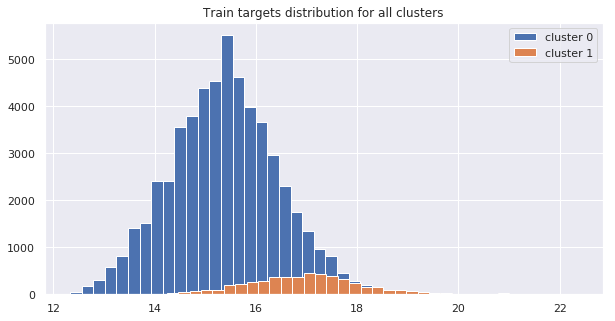

In [6]:
plt.figure(figsize=(10,5))
plt.hist(y_train.values[train['labels']==0],bins=40,label='cluster 0')
plt.hist(y_train.values[train['labels']==1],bins=40,label='cluster 1')
# plt.hist(y_train.values[train['labels']==2],bins=70,label='cluster 2')
# plt.hist(y_train.values[train['labels']==3],bins=70,label='cluster 3')
plt.legend()
plt.title('Train targets distribution for all clusters')
# plt.xlim((10,22))
plt.show()

In [16]:
labels_test.value_counts()

1.0    9178
0.0     822
Name: lonlat, dtype: int64

In [7]:
# labels_test[np.isnan(labels_test)].shape()
cross_val_score(
    X = X_train.select_dtypes(include=[np.number]),
    y = labels_train,
    estimator = LGBMClassifier(),
    cv = 5,
    scoring = 'roc_auc')

array([0.99884859, 0.99875134, 0.99974263, 0.99891858, 0.99983075])

## Parking Recovery
- 'parking_way' 車位停放方式 // 3 
- 'parking_area' 車位面積
- 'parking_price'

Q: 驗證 具備停車面積，就一定有停車價位， vice versa.

What I Found:

Q: 需要買停車位的縣市，應該是大城市(cnt/%)
- [x]  新北，台北，桃園，台中，高雄，新竹 (cnt)
- [x]  新北，桃園，台北，新竹，台中，基隆 (%)

Q: No need 買停車位的縣市，應該是small城市 (cnt/%)
- [ ]  新北，台北，桃園，台中，高雄 (cnt)
- [x]  苗栗，屏東，台南，高雄，彰化 (%)

```python
D = {
3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 
5:'Pingtung'}

Temp = {}
Ans = {}
for i in combine['city'].unique():
    Temp[i] = combine[(combine['parking_area'].isnull())&(combine['city']==i)].shape[0]    
    Temp[i]/= combine[combine['city']==i].shape[0]
    Ans[D[i]] = Temp[i]

sorted(Ans.items(), key=operator.itemgetter(1))
```

有停車面積，跟價位，不會具備 `parking_way = 2`
```
combine[combine['parking_price'].notnull()]['parking_way'].value_counts()
combine[combine['parking_area'].notnull()]['parking_way'].value_counts()
```
   - Hypothesis: 停車方式2 = 路邊停車？
       - [x] 停車方式2，高到低：屏東，苗栗，彰化，台南 (9) 
       


In [35]:
D = {
3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 14:'Tainan', 21:'Kaohsiung', 
5:'Pingtung'}

Temp = {}
Ans = {}
for i in combine['city'].unique():
    Temp[i] = combine[(combine['parking_way']==2)&(combine['city']==i)].shape[0]    
    Temp[i]/= combine[combine['city']==i].shape[0]
    Ans[D[i]] = Temp[i]

sorted(Ans.items(), key=operator.itemgetter(1))

[('TaoYuan', 0.678219627873039),
 ('Hsinchu', 0.6814362108479756),
 ('NewTaipei', 0.7084097458737229),
 ('Taichung', 0.7306559886939112),
 ('Taipei', 0.7999680587718597),
 ('Kaohsiung', 0.8109474137003979),
 ('Keelung', 0.8235294117647058),
 ('Tainan', 0.9024122807017544),
 ('Changhua', 0.956020942408377),
 ('Miaoli', 0.9643478260869566),
 ('Pingtung', 0.978839590443686)]

## Hypothesis Same Building ot not ?
- are these 1 floor sold out apartment or not ?
    - The price of these 1 floor in big city

- 交易樓層1，數量排行 by city
    1. Pt 2nd
    2. ML 1st
    3. 彰 5 (city)
    4. TP 4
    5. NewTP 4
    6. 中 7 (city)
    7. HC 7
    
- def 鄉下：屏東，台南，苗栗，彰化

### 一樓 ＶＳ 公寓， 
    1. 雙北，一樓中位數都高於，公寓
    2. 最低價都是一樓最高
    3. 最高價除了「台南，屏東」，其餘都是 「公寓」屌打「一樓」
    - 一樓都是屬於郊區？？？？
    - quantile(0.7) 可以看出房價差異大 台中台南
```python
for i in train['city'].unique(): 
    print(D[i],train[(train['txn_floor']==1)&(train['city']==i)]['total_price'].quantile(0.9))
    print(D[i],train[(train['txn_floor']!=1)&(train['city']==i)]['total_price'].quantile(0.9),'\n')

```
```python
3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 
14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'```

In [97]:
# train[train['city']==21].groupby(['txn_floor'])['total_price'].max()
# 中位數
# 台北越高樓越貴（合理）(13樓有 存在精華區)
# 新北最高樓有 outlier (28層樓 窮人區？)
# 台中第二高樓有 outlier (27層樓 鬧鬼)
# 苗栗第二高樓有 outlier (9 鬧鬼？)
# 屏東符合

# 最高價
# 台北 一樓最貴（獨棟？）
# 新北，大致上一樓很貴，有某些公寓更高價（做地段鎖定）
# 桃園一樓最貴
# 新竹 1 2 3  樓 高其他一個 order
# 台中 一樓最貴（獨棟？）(做地段鎖定)
# 新竹，1-3樓 最貴 差一個 order (why)
# * 台南越高的越便宜 ＠＠
# 高雄穩定，獨棟最貴
# Pingtung 一樓最貴

# 計算，一樓層的面積～

txn_floor
1.0     9.520117e+07
2.0     3.984692e+07
3.0     4.196448e+07
4.0     7.955997e+07
5.0     7.955992e+07
6.0     2.519645e+07
7.0     4.678733e+07
8.0     2.595019e+07
9.0     7.090713e+07
10.0    2.125785e+07
11.0    4.705268e+07
12.0    7.090713e+07
13.0    1.421501e+07
14.0    5.327940e+07
15.0    8.177464e+07
16.0    9.783634e+07
17.0    8.177464e+07
18.0    1.227714e+08
19.0    8.177464e+07
20.0    1.474840e+08
21.0    6.567068e+07
22.0    1.098802e+08
23.0    6.057029e+07
24.0    3.143043e+07
25.0    4.548290e+07
27.0    3.811297e+07
Name: total_price, dtype: float64

## Unit Area price `total_price` / `building_area`


```python
3:'Keelung',13:'Taipei', 7:'NewTaipei', 10:'TaoYuan', 9:'Hsinchu', 
17:'Miaoli', 12:'Taichung', 6:'Changhua', 
14:'Tainan', 21:'Kaohsiung', 5:'Pingtung'```

In [99]:
train['price_per_building_area'] = train['total_price'] / train['building_area']

In [111]:
# for i in train['city'].unique(): 
#     print(D[i],train[(train['txn_floor']==1)&(train['city']==i)]['building_area'].median())
#     print(D[i],train[(train['txn_floor']!=1)&(train['city']==i)]['building_area'].median(),'\n')
# for i in [3,13,7,10,9,17,12,6,14,21,5]:
#     print(D[i], train[train['city']==i].groupby(['txn_floor'])['price_per_building_area'].var())

# 發現變異數，train 特定縣市的樓層只有一筆

In [122]:
train.columns.values

array(['building_id', 'building_material', 'city', 'txn_dt',
       'total_floor', 'building_type', 'building_use',
       'building_complete_dt', 'parking_way', 'parking_area',
       'parking_price', 'txn_floor', 'land_area', 'building_area', 'town',
       'lat', 'lon', 'village_income_median', 'town_population',
       'town_area', 'town_population_density', 'doc_rate', 'master_rate',
       'bachelor_rate', 'jobschool_rate', 'highschool_rate',
       'junior_rate', 'elementary_rate', 'born_rate', 'death_rate',
       'marriage_rate', 'divorce_rate', 'village', 'N_50', 'N_500',
       'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_index_50',
       'I_100', 'I_250', 'I_500', 'I_index_500', 'I_1000', 'I_index_1000',
       'I_5000', 'I_index_5000', 'I_10000', 'I_index_10000', 'I_MIN',
       'II_10', 'II_50', 'II_index_50', 'II_100', 'II_250', 'II_500',
       'II_index_500', 'II_1000', 'II_index_1000', 'II_5000',
       'II_index_5000', 'II_10000', 'II_index_10000', 'II_MIN', 'I

In [130]:
train[(train['txn_floor']==27)&(train['city']==12)][[ 'txn_dt',
       'total_floor', 'building_type', 'building_use',
       'building_complete_dt', 'parking_way', 'parking_area',
       'parking_price', 'txn_floor', 'land_area', 'building_area']]

txn_dt  total_floor  building_type  building_use  building_complete_dt  \
1757   19634           28              0             2                 12907   
5111   19634           28              0             2                 12907   

      parking_way  parking_area  parking_price  txn_floor  land_area  \
1757            0           NaN   43791.947141       27.0  14.803422   
5111            0           NaN   49461.515554       27.0   6.051717   

      building_area  
1757      21.326596  
5111       6.045859

In [131]:
test[(test['CityTownVillage']=='120029000244600')][['txn_dt',
       'total_floor', 'building_type', 'building_use',
       'building_complete_dt', 'parking_way', 'parking_area',
       'parking_price', 'txn_floor', 'land_area', 'building_area']]

txn_dt  total_floor  building_type  building_use  building_complete_dt  \
5304   18695            3              4             2                 12207   
6026   19698           17              0             2                 12603   
7718   19983           17              2             2                 12603   
9780   18493           17              0             2                 12603   

      parking_way  parking_area  parking_price  txn_floor  land_area  \
5304            2           NaN            NaN        NaN  71.527635   
6026            0      5.068286   43791.947141       16.0  16.482126   
7718            2           NaN            NaN       15.0   4.181031   
9780            0           NaN   38363.467549        8.0  11.387227   

      building_area  
5304      14.129836  
6026      14.129836  
7718       2.252256  
9780       9.498317

In [144]:
(combine['txn_dt'] - combine['building_complete_dt'])/365
# combine[['building_complete_dt','txn_dt']]/365).describe()

0       33.980822
1       29.904110
2       36.331507
3        5.643836
4       37.745205
5       32.378082
6       10.726027
7       17.126027
8       30.558904
9       27.572603
10      28.958904
11       7.200000
12      20.136986
13      40.975342
14      21.035616
15      10.052055
16      33.531507
17      23.043836
18      19.041096
19      29.567123
20      17.706849
21      42.356164
22      31.326027
23      26.380822
24       6.898630
25       9.605479
26       8.704110
27      34.673973
28       9.709589
29      20.328767
          ...    
9970    17.893151
9971    28.816438
9972    32.756164
9973    39.479452
9974     6.912329
9975    21.778082
9976    49.742466
9977     6.772603
9978    25.720548
9979    19.580822
9980    23.205479
9981    13.147945
9982    34.158904
9983     8.139726
9984    15.147945
9985     9.597260
9986    29.189041
9987    11.312329
9988    28.501370
9989    43.246575
9990    28.706849
9991    34.545205
9992    10.717808
9993     3.257534
9994    22

## Target Encoding

In [8]:
def sk_contr_te(train, test):   
    # use target encoding to encode two categorical features
    train['CityTownVillage'] = train['city'].apply(lambda x: str((int(x*100)))) + \
                                train['town'].apply(lambda x: str((int(x*100)))) + \
                                train['village'].apply(lambda x: str((int(x*100))))
    test['CityTownVillage'] = test['city'].apply(lambda x: str((int(x*100)))) + \
                                test['town'].apply(lambda x: str((int(x*100)))) + \
                                test['village'].apply(lambda x: str((int(x*100))))

    target_cate = ['CityTownVillage']
    target_num = ['total_price']
    for i in target_cate:
        for j in target_num:
            enc = TargetEncoder(cols=[i]).fit(train[i], train[j])

            training_numeric_dataset = enc.transform(train[i], train[j])#.rename(cols={'city':'city_targ'})
            testing_numeric_dataset = enc.transform(test[i])

            training_numeric_dataset.rename(columns={i:i +'_targ_'+j}, inplace=True)
            testing_numeric_dataset.rename(columns={i:i +'_targ_'+j}, inplace=True)

            train[i +'_targ_' + j] = training_numeric_dataset
            test[i +'_targ_' + j] = testing_numeric_dataset
            del training_numeric_dataset, testing_numeric_dataset;
            gc.collect()
            
    return train, test

In [10]:
dt_today = datetime.today()

def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.savefig('shap_{}.png'.format(dt_today.strftime("_%m_%d")))
    plt.tight_layout()
    plt.show()
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_{}.png'.format(dt_today.strftime("_%m_%d")))
    
def hit_rate(y_true, y_pred):
    return np.mean(np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)]))

def Mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true)/y_true))

def score(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return (np.round(hit_rate(y_true, y_pred), 4)*1e4 + 1 - Mape(y_true, y_pred))

def model(trn, sub, folds):
    print('Official Metrics Test Score: ',score(np.array([1000,1000,1000]), np.array([1300,1100,1050])))
    trn_shape = trn.shape[0]
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat']]
    combine = pd.concat([trn[feats], sub[feats]])
    
    average = 0
    for col in feats:
        average += np.array(combine[col].rank(ascending=1))
    average = average/len(feats)
    combine['AVERAGE'] = average
    feats = [f for f in trn.columns if f not in ['building_id', 'total_price','lonlat','CityTownVillage']]

    trn = combine.iloc[:trn_shape, :]
    sub = combine.iloc[trn_shape:, :]
    
    del combine; gc.collect()
    X = trn[feats]
    y = np.log1p(target)    
    
    sss = KFold(n_splits=folds, shuffle=True, random_state=0)
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros(trn.shape[0])
    sub_preds = np.zeros(sub.shape[0])
    
    for fold_, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = LGBMRegressor(n_estimators=100000,
                            learning_rate =  0.01,#0.003,
                            num_leaves=150,                
                            feature_fraction = 0.5, # sub_feature
                            bagging_fraction= 0.8, # subsample
#                             lambda_l2 = 1,
#                             bagging_freq= 5,
#                             min_data_in_leaf= 30,
#                             min_sum_hessian_in_leaf= 10,
#                             tree_learner='serial',
#                             boost_from_average='false',
                            silent=-1,
                            verbose=-1,
                            n_josb=-1)
        
        clf.fit(X_train, y_train, eval_set=[ (X_train, y_train),(X_test, y_test )], 
#                 eval_metric= 'mse', 
#                 categorical_feature  = ['city','town','village'],
                verbose= 7000, early_stopping_rounds= 3000)
        
        y_pred = np.expm1(clf.predict(X_test, num_iteration=clf.best_iteration_))
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate plus MAPE: {}'.format(score(np.expm1(y_test), y_pred)),'\n')
        print('Fold {}'.format(fold_ + 1), 'Hit-Rate {}'.format(hit_rate(np.expm1(y_test), y_pred)),'\n')

        oof_preds[test_index] = y_pred
        sub_preds += clf.predict(sub[feats], num_iteration=clf.best_iteration_) / sss.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(X_test)[:,:sub[feats].shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = fold_+ 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Full Hit-Rate plus MAPE score: {}'.format(score(target, oof_preds),'\n'))

#     display_importances(feature_importance_df)
#     display_shapley_values(feature_importance_df)
    return feature_importance_df, oof_preds, sub_preds

feature_importance_df, oof_preds, sub_preds = model(train, test, folds=5)

Official Metrics Test Score:  6667.85
Training until validation scores don't improve for 3000 rounds.
[7000]	training's l2: 0.00220999	valid_1's l2: 0.0387612
[14000]	training's l2: 0.000570686	valid_1's l2: 0.0385672
Early stopping, best iteration is:
[16166]	training's l2: 0.000420097	valid_1's l2: 0.0385624
Fold 1 Hit-Rate plus MAPE: 5693.869735326931 

Fold 1 Hit-Rate 0.5693333333333334 

Training until validation scores don't improve for 3000 rounds.
[7000]	training's l2: 0.00219636	valid_1's l2: 0.0381727
[14000]	training's l2: 0.000490431	valid_1's l2: 0.0380125
[21000]	training's l2: 0.000170541	valid_1's l2: 0.0380025
Early stopping, best iteration is:
[19324]	training's l2: 0.000212472	valid_1's l2: 0.038
Fold 2 Hit-Rate plus MAPE: 5708.865466012232 

Fold 2 Hit-Rate 0.57075 

Training until validation scores don't improve for 3000 rounds.
[7000]	training's l2: 0.00222215	valid_1's l2: 0.0370258
[14000]	training's l2: 0.000494956	valid_1's l2: 0.036939
Early stopping, best it

KeyboardInterrupt: 

```
? / 修正lonlat concat / citytownvillage target encoding

Fold 1 Hit-Rate plus MAPE: 5728.869505539651 / 0.57208 /

Fold 2 Hit-Rate plus MAPE: 0.57283 / 0.5725 /

Fold 3 Hit-Rate plus MAPE: 0.5678 / 0.56983 / 

Fold 4 Hit-Rate plus MAPE: 5689.870057726021  / 0.57033 / 

Fold 5 Hit-Rate plus MAPE: 5684.870993463363  / 0.5673333 /

Full Hit-Rate plus MAPE score:   / 5704.869387335924 /

```

- [x] 修正concat問題

In [27]:
combine['CityTownVillage'] = combine['city'].apply(lambda x: str((int(x*100)))) + \
                            combine['town'].apply(lambda x: str((int(x*100)))) + \
                            combine['village'].apply(lambda x: str((int(x*100))))
        
combine['CityTownVillage'].nunique(), train['lonlat'].nunique(), test['lonlat'].nunique()

(4322, 2402, 1486)

# Error Analysis
    - 從統計看出 差異最大 std 來自於 real Max 被低估

In [19]:
def hit_rate_all(y_true, y_pred):
    return np.array([1 if i <= 0.1 else 0 for i in np.abs((y_pred - y_true)/y_true)])

train['hit_rate'] = hit_rate_all(target, oof_preds)
train['pred'] = oof_preds
train[train['hit_rate']==0].shape
train[train['hit_rate']==0].to_csv('error.csv', index=False)

(25775, 239)